# Face Mask Detector

## Importing Necessary Libraries

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
import jovian
%matplotlib inline

<IPython.core.display.Javascript object>

## Importing Dataset

In [2]:
# Transforms to apply on the dataset.
# We are resizing the image to (224,224) followed by random horizontal flip and converting image to tensors
tfms = tt.Compose([
    tt.Resize((224,224)),
    tt.RandomHorizontalFlip(),
    tt.ToTensor()
])

In [3]:
# Importing the Dataset from folder RMDFDATA2, the images in the original dataset were used to create new images with blur, noise, and rotation of the image
d = ImageFolder('RMDFDATA2',transform=tfms)

In [4]:
d

Dataset ImageFolder
    Number of datapoints: 9016
    Root location: RMDFDATA2
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [5]:
classes = d.class_to_idx
classes

{'face': 0, 'mask': 1}

face means the person in the image is not wearing a mask.

## Example of the dataset

In [6]:
image,label = d[2500]
print('Image Size:',image.shape)
print('Label:',d.classes[label])
datasetLabels = d.class_to_idx

Image Size: torch.Size([3, 224, 224])
Label: face


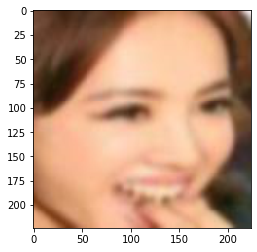

In [7]:
plt.imshow(image.permute(1,2,0))

# Data Loader

Below code is used to make sure that the training and validation sets contain equal amount of both the classes

In [8]:
targets = d.targets

In [9]:
train_idx, valid_idx= train_test_split(np.arange(len(targets)),test_size=0.2,shuffle=True,stratify=targets)

In [10]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [11]:
batch_size = 64

In [12]:
trainDL = DataLoader(d,batch_size=batch_size,pin_memory=True,sampler=train_sampler)
valDL = DataLoader(d,batch_size=batch_size*2,pin_memory=True,sampler=valid_sampler)

Let's see the distribution of classes in train and validation set

In [13]:
mask = 0
face = 0
for i in trainDL:
    image,label = i
    for l in label:
        if d.classes[l]=='mask':
            mask+=1
        else:
            face+=1
print('Face Label Images in Train Set:',face)
print('Mask Label Images in Train Set:',mask)

Face Label Images in Train Set: 3688
Mask Label Images in Train Set: 3524


In [14]:
mask = 0
face = 0
for i in valDL:
    image,label = i
    for l in label:
        if d.classes[l]=='mask':
            mask+=1
        else:
            face+=1
print('Face Label Images in Validation Set:',face)
print('Mask Label Images in Validation Set:',mask)

Face Label Images in Validation Set: 922
Mask Label Images in Validation Set: 882


As we can see, the class labels are almost equally distributed amongst train and test sets

# Move to GPU Code

Below code is used to make sure that the model and the data is transferred to a cuda graphics card if available, else RAM

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Custom Data Loader which transfers the data to cuda graphics card, or RAM whichever available, and then returns the data
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
trainDL = DeviceDataLoader(trainDL,device)
valDL = DeviceDataLoader(valDL,device)

# Model 

We will try to make a simple CNN model instead of using pre trained ones

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
                                    nn.Conv2d(3,8,(3,3),stride=1,padding=1), # 3x224x224 => 8x224x224
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(8,64,(3,3),padding=1),# 8x112x112 => 64x112x112
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(64,128,(3,3),padding=1),# 64x56x56 => 128x56x56
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2,2), # 128x56x56 => 128x24x24
                                    nn.AdaptiveAvgPool2d(output_size=(6,6)),
                                    nn.Flatten()
                                    )
        
        self.linear = nn.Sequential( nn.Linear(4608,2048,bias=True),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(2048,100,bias=True),
                                    nn.Dropout(0.5),
                                    nn.ReLU(),
                                    nn.Linear(100,2,bias=True))
        
        
    def training_step(self,batch):
        image,label = batch
        out = self(image)
        loss = F.cross_entropy(out,label)
        return loss
    
    
    def forward(self,batch):
        out = self.network(batch)
        out = self.linear(out)
        return out
    
    
    def validation_step(self,batch):
        image,label = batch
        out = self(image)
        loss = F.cross_entropy(out,label)
        _, y_pred = torch.max(out,dim=1)
        label = label.cpu().numpy()
        y_pred = y_pred.detach().cpu().numpy()
        accuracy = accuracy_score(label,y_pred)
        precision = recall_score(label,y_pred,average='micro')
        print('Confusion Matrix for Evaluation:')
        print(confusion_matrix(label,y_pred))
        return {'val_loss':loss.detach(),'val_accuracy':torch.Tensor([accuracy]),'precision':torch.Tensor([precision])}
    
    
    def validation_epoch_end(self,outputs):
        val_loss = [x['val_loss'] for x in outputs]
        val_loss_n = torch.stack(val_loss).mean()
        val_score = [x['val_accuracy'] for x in outputs]
        val_score_n = torch.stack(val_score).mean()
        precision = [x['precision'] for x in outputs]
        precision = torch.stack(precision).mean().item()
        return {'val_loss':val_loss_n,'val_score':val_score_n,'precision':precision}
    
    
    def epoch_end(self,epoch,result):
        print('Epoch {}: train_loss: {:.4f} val_loss: {:.4f} val_score: {:.4f} precision: {}'.format(epoch,result['train_loss'],result['val_loss'],result['val_score'],result['precision']))

## Defining the fit, evaluate functions and training the Neural Network

In [18]:
model = CNN()
model.to(device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): AdaptiveAvgPool2d(output_size=(6, 6))
    (12): Flatten()
  )
  (linear): Sequential(
    (0): Linear(in_features=4608, out_features=2048, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=100, 

In [19]:
@torch.no_grad()
def evaluate():
    model.eval()
    result = [model.validation_step(batch) for batch in valDL]
    return model.validation_epoch_end(result)

def fit(num_epochs, lr, opt_func, grad_clip=None):
    history=[]
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters(),lr,weight_decay=1e-4)
    for i in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        train_loss=[]
        for data in trainDL:
            loss = model.training_step(data)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate()
        result['train_loss'] = torch.stack(train_loss).mean().item()
        model.epoch_end(i,result)
        history.append(result)
    return history

def fitall(num_epochs, lr, opt_func, grad_clip=None):
    history=[]
    torch.cuda.empty_cache()
    optimizer = opt_func(model.parameters(),lr,weight_decay=1e-3)
    for i in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        train_loss=[]
        for data in trainDL:
            loss = model.training_step(data)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
        torch.cuda.empty_cache()
        for data in valDL:
            loss = model.training_step(data)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
#         result = evaluate()
#         result['train_loss'] = torch.stack(train_loss).mean().item()
#         model.epoch_end(i,result)
#         history.append(result)
    return history


In [20]:
torch.cuda.empty_cache()

## Lets check the accuracy of our neural network 

In [21]:
evaluate()

Confusion Matrix for Evaluation:
[[ 0 76]
 [ 0 52]]
Confusion Matrix for Evaluation:
[[ 0 64]
 [ 0 64]]
Confusion Matrix for Evaluation:
[[ 0 71]
 [ 0 57]]
Confusion Matrix for Evaluation:
[[ 0 59]
 [ 0 69]]
Confusion Matrix for Evaluation:
[[ 0 70]
 [ 0 58]]
Confusion Matrix for Evaluation:
[[ 0 73]
 [ 0 55]]
Confusion Matrix for Evaluation:
[[ 0 64]
 [ 0 64]]
Confusion Matrix for Evaluation:
[[ 0 71]
 [ 0 57]]
Confusion Matrix for Evaluation:
[[ 0 69]
 [ 0 59]]
Confusion Matrix for Evaluation:
[[ 0 48]
 [ 0 80]]
Confusion Matrix for Evaluation:
[[ 0 58]
 [ 0 70]]
Confusion Matrix for Evaluation:
[[ 0 64]
 [ 0 64]]
Confusion Matrix for Evaluation:
[[ 0 64]
 [ 0 64]]
Confusion Matrix for Evaluation:
[[ 0 68]
 [ 0 60]]
Confusion Matrix for Evaluation:
[[0 3]
 [0 9]]


{'val_loss': tensor(0.6932, device='cuda:0'),
 'val_score': tensor(0.5047),
 'precision': 0.504687488079071}

Without any training, our neural network has an accuracy of 50% with a precision of 50% as well, although we can see from the confusion matrix that our neural network fails to recognize any data of class 0.  

Let's Train it Now!!

In [22]:
hist = []

In [23]:
epochs = 4
lr = 0.01
optim = torch.optim.SGD
grad_clip = 0.1

In [24]:
hist+=fit(epochs,lr,optim,grad_clip)

Confusion Matrix for Evaluation:
[[67  5]
 [ 3 53]]
Confusion Matrix for Evaluation:
[[61  4]
 [ 2 61]]
Confusion Matrix for Evaluation:
[[57  5]
 [ 7 59]]
Confusion Matrix for Evaluation:
[[71  3]
 [ 3 51]]
Confusion Matrix for Evaluation:
[[57  8]
 [ 7 56]]
Confusion Matrix for Evaluation:
[[56  6]
 [ 5 61]]
Confusion Matrix for Evaluation:
[[52  5]
 [ 2 69]]
Confusion Matrix for Evaluation:
[[61  5]
 [ 6 56]]
Confusion Matrix for Evaluation:
[[58  3]
 [ 5 62]]
Confusion Matrix for Evaluation:
[[55  7]
 [ 3 63]]
Confusion Matrix for Evaluation:
[[59  8]
 [ 2 59]]
Confusion Matrix for Evaluation:
[[62  4]
 [ 5 57]]
Confusion Matrix for Evaluation:
[[58  2]
 [ 2 66]]
Confusion Matrix for Evaluation:
[[63  9]
 [ 4 52]]
Confusion Matrix for Evaluation:
[[11  0]
 [ 0  1]]
Epoch 0: train_loss: 0.3980 val_loss: 0.2031 val_score: 0.9323 precision: 0.9322916865348816
Confusion Matrix for Evaluation:
[[68  3]
 [ 3 54]]
Confusion Matrix for Evaluation:
[[66  5]
 [ 2 55]]
Confusion Matrix for Ev

In [25]:
epochs = 2

In [26]:
hist+=fit(epochs,lr,optim,grad_clip)

Confusion Matrix for Evaluation:
[[67  1]
 [ 6 54]]
Confusion Matrix for Evaluation:
[[69  0]
 [ 8 51]]
Confusion Matrix for Evaluation:
[[66  0]
 [ 9 53]]
Confusion Matrix for Evaluation:
[[69  0]
 [ 8 51]]
Confusion Matrix for Evaluation:
[[56  0]
 [11 61]]
Confusion Matrix for Evaluation:
[[66  0]
 [12 50]]
Confusion Matrix for Evaluation:
[[67  0]
 [ 6 55]]
Confusion Matrix for Evaluation:
[[64  0]
 [ 9 55]]
Confusion Matrix for Evaluation:
[[66  1]
 [11 50]]
Confusion Matrix for Evaluation:
[[60  0]
 [ 9 59]]
Confusion Matrix for Evaluation:
[[63  0]
 [ 8 57]]
Confusion Matrix for Evaluation:
[[66  0]
 [ 8 54]]
Confusion Matrix for Evaluation:
[[69  0]
 [ 8 51]]
Confusion Matrix for Evaluation:
[[66  0]
 [ 7 55]]
Confusion Matrix for Evaluation:
[[6 0]
 [3 3]]
Epoch 0: train_loss: 0.1265 val_loss: 0.1826 val_score: 0.9198 precision: 0.9197916388511658
Confusion Matrix for Evaluation:
[[72  1]
 [ 0 55]]
Confusion Matrix for Evaluation:
[[58  2]
 [ 2 66]]
Confusion Matrix for Evalua

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in hist]
    val_losses = [x['val_loss'] for x in hist]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

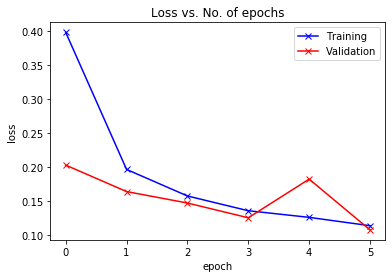

In [28]:
plot_losses(hist)

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

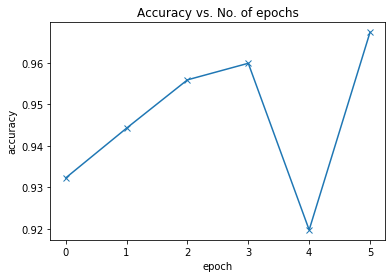

In [34]:
plot_accuracies(hist)

## Testing the Model on some images I collected

In [36]:
test_data = ImageFolder('test_data',transform=tt.ToTensor())
# plt.imshow(test_data[4][0].permute(1,2,0))
# # test_data[0]

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    model.eval()
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    print(yb.detach())
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return d.classes[preds[0].item()]


tensor([[-4.6579,  4.2073]], device='cuda:0')
Predicted: mask


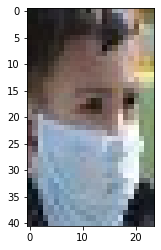

In [39]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[ 1.5044, -1.9159]], device='cuda:0')
Predicted: face


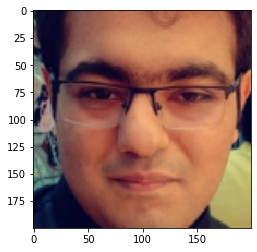

In [41]:
img, label = test_data[1]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[ 0.8381, -1.2303]], device='cuda:0')
Predicted: face


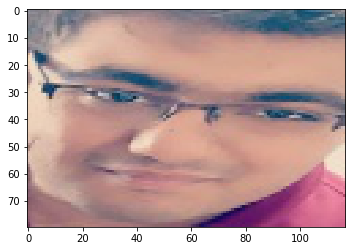

In [42]:
img, label = test_data[2]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[-3.3853,  3.1284]], device='cuda:0')
Predicted: mask


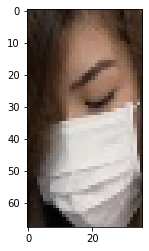

In [44]:
img, label = test_data[3]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[ 1.9237, -2.2853]], device='cuda:0')
Predicted: face


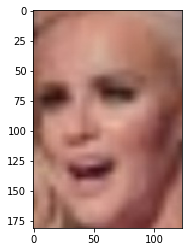

In [45]:
img, label = test_data[4]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

tensor([[-5.7704,  5.5084]], device='cuda:0')
Predicted: mask


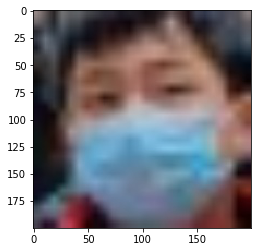

In [46]:
img, label = test_data[5]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [47]:
torch.save(model.state_dict(), 'mask_best_model.pth')

In [ ]:
# Project name used for jovian.commit
project_name = 'faceMaskDetector'

In [48]:
jovian.log_hyperparams({'epochs':6,
                       'lr':0.01,
                       'optimizer':optim.__name__,
                       'grad_clip':0.1})

[jovian] Hyperparams logged.


In [50]:
jovian.log_metrics({'val_loss':'0.1080',
  'val_score': '0.9674',
  'precision': '0.9673611521720886',
  'train_loss': '0.11419515311717987'})

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None,filename='FaceMaskDetector2.ipynb')